<a href="https://colab.research.google.com/github/Andrew1021/CV_SoSe21/blob/main/%C3%9Cbung%201/CV_Uebung_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision SoSe 21
## Übung 1: UMBILDUNG

## Import packets

In [66]:
# Import required packets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from math import cos, sin
!pip install pillow
from PIL import Image

## Load test image

In [67]:
# mount google drive first
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
%ls drive/MyDrive/CV

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ambassadors.jpg  gletscher.jpg


In [68]:
# Load image
#from IPython.display import Image

#gletscher = Image("https://github.com/Andrew1021/CV_SoSe21/blob/main/%C3%9Cbung%201/gletscher.jpg")
#ambassadors = Image("https://github.com/Andrew1021/CV_SoSe21/blob/main/%C3%9Cbung%201/ambassadors.jpg")

#gletscher = io.imread("https://raw.githubusercontent.com/Andrew1021/CV_SoSe21/main/%C3%9Cbung%201/gletscher.jpg?token=AMAJKBQGCKI4PXT6N6ASVWTANMMXY", as_gray=True)
#ambassadors = io.imread("https://raw.githubusercontent.com/Andrew1021/CV_SoSe21/main/%C3%9Cbung%201/ambassadors.jpg?token=AMAJKBXCYQAPGNQC5Q5RGQTANMR4U", as_gray=False)

gletscher = Image.open("drive/MyDrive/CV/gletscher.jpg")
ambassadors = Image.open("drive/MyDrive/CV/ambassadors.jpg")
print(len(gletscher.getbands()))

3


## Generate image matrix A

In [ ]:
# get shape of image and convert image to float if not already
if True:
    rows, columns, channels = gletscher.shape
    if np.issubdtype(gletscher.dtype, np.uint8):
        gletscher =  gletscher.astype("float32")
        
    # normalization (Output_channel = 255 * (Input_channel - min) / (max-min))
    gletscher /= 255.0   # Uses 1+gletscher.size divisions

    # predefinition matrix A and vector a0_ of image size
    A_gletscher = np.empty([rows, columns])
    a0_gletscher = np.empty([rows])

    # show image
    plt.imshow(gletscher, cmap="gray")
    #io.imshow(gletscher)
plt.show()

if True:
    rows, columns, channels = ambassadors.shape
    if np.issubdtype(ambassadors.dtype, np.uint8):
        ambassadors =  ambassadors.astype("float32")
        
    # normalization (Output_channel = 255 * (Input_channel - min) / (max-min))
    ambassadors /= 255.0   # Uses 1+gletscher.size divisions

    # predefinition matrix A and vector a0_ of image size
    A_ambassadors = np.empty([rows, columns])
    a0_ambassadors = np.empty([rows])

    # show image
    plt.imshow(ambassadors)
    #io.imshow(ambassadors)
plt.show()

## a) Function for affin transformation of test image

In [139]:
def affin_transform_image(A, a0_, image, interpolation="bilinear"):
    """
    Eine Python-Funktion, mit der sich ein Bild affin transformieren
    läßt. Übergabeparameter sind die Matrix A, der Verschiebungsvektor a0_ und das
    Eingangsbild, zurückgegeben wird das affin verzerrte Ausgangsbild. 
    Der Benutzer kann dabei zwischen Nächster-Nachbar- und bilinearer Interpolation
    wählen. 
    Alle Pixel, deren Ausgangsposition außerhalb des Eingangsbildes
    liegen, werden auf 0 gesetzt. 
    Die Funktion kann sowohl Grauwert- als auch Farbbilder verarbeiten.

    :param A: The rotation matrix a for the image transformation
    :type A: float32
    :param a0_: The shift vector for the image transformation
    :type a0_: float32
    :param image: The entrance image, which shoud be affin tranformed
    :type image: float32
    :param interpolation: The interpolation type performed on the image (default bilinear)
    :type interpolation: String
    :param color: Determine if the images is colored or grey (default False)
    :type color: bool

    :return: affin_image: The affin transformed image
    :rtype: float32
    """

    # # affine level tranformation (rotation, scaling)
    # x_ = A * image + a0_

    # # indirekte Umbildung
    # rows, columns = image.shape
    # scale = 1.2
    # bildmatrix = np.empty([scale * rows, scale * columns])

    # # Koordinaten der Pixelmittelpunkte mit der inversen Transformation auf die ursprüngliche
    # # Position im Ausgangsbild zurückgerechnet und der dortige Grauwert ausgelesen
    # # numpy.linalg.inv() # or transpose matrix
    # affin_image = numpy.linalg.inv(A) * x_ + a0_

    # # bilineare Interpolation gX = A4g(P1) + A3g(P2) + A2g(P3) + A1g(P4).
    # gX = A4g(P1) + A3g(P2) + A2g(P3) + A1g(P4)

    # affin transformation
    #rows, columns, channels = image.shape # for greyscale gletscher image
    rows = image.height
    columns = image.width
    channels = len(image.getbands())

    affin_image = np.empty((rows, columns, channels), dtype=np.float32)
    np_image = np.asarray(image)
    x_max, y_max = np_image.shape[0] - 1, np_image.shape[1] - 1
    for i, row in enumerate(np_image):
        for j, col in enumerate(row):
            pixel_data = np_image[i, j, :]
            input_coords = np.array([i, j, 1])
            i_out, j_out, _ = A @ input_coords
            if i_out > x_max:
                continue
            if  i_out < 0:
                continue
            if j_out > y_max:
                continue
            if  j_out < 0:
                continue
            affin_image[int(i_out), int(j_out), :] = pixel_data
    affin_image = affin_image/affin_image.max()

    plt.figure(figsize=(5, 5))
    plt.imshow(affin_image)

    A_inv = np.linalg.inv(A)

    # nearest neighbors interpolation
    def nearest_neighbors(i, j, M, A_inv):
        x_max, y_max = M.shape[0] - 1, M.shape[1] - 1
        input_coords =  np.array([i, j, 1])
        x, y, _ = A_inv @ input_coords
        if np.floor(x) == x and np.floor(y) == y:
           x, y = int(x), int(y)
        if x > x_max:
            return 0
        if  x < 0:
            return 0
        if y > y_max:
            return 0
        if  y < 0:
            return 0
        if np.abs(np.floor(x) - x) < np.abs(np.ceil(x) - x):
            x = int(np.floor(x))
        else:
            x = int(np.ceil(x))
        if np.abs(np.floor(y) - y) < np.abs(np.ceil(y) - y):
            y = int(np.floor(y))
        else:
            y = int(np.ceil(y))
        return M[x, y, :]

    # biliear interpolation
    def biliear(i, j, M, A_inv):
        x_max, y_max = M.shape[0] - 1, M.shape[1] - 1
        input_coords =  np.array([i, j, 1])
        x, y, _ = A_inv @ input_coords
        if np.floor(x) == x and np.floor(y) == y:
           x, y = int(x), int(y)
        if x > x_max:
            return 0
        if  x < 0:
            return 0
        if y > y_max:
            return 0
        if  y < 0:
            return 0
        x1 = int(np.floor(x))
        x2 = int(np.ceil(x))
        y1 = int(np.floor(y))
        y2 = int(np.ceil(y))
        h = x - x1
        v = y - y1
        gx = (1-h)*(1-v)*np_image[x1,y1,:]+(h)*(1-v)*np_image[x2,y1,:]+(1-h)*(v)*np_image[x1,y2,:]+(h)*(v)*np_image[x2,y2,:]
        return gx

    nn_affin_image = np.empty((rows, columns, channels), dtype=np.float32)
    for i, row in enumerate(nn_affin_image):
        for j, col in enumerate(row):
            if interpolation=="naechster-nachbar":
                nn_affin_image[i, j, :] = nearest_neighbors(i, j, np_image, A_inv)
            if interpolation=="bilinear":
                nn_affin_image[i, j, :] = biliear(i, j, np_image, A_inv)

    nn_affin_image = nn_affin_image/nn_affin_image.max()

    plt.figure(figsize=(5, 5))
    plt.imshow(nn_affin_image)

    if interpolation=="naechster-nachbar":
        # affin transformation and nearest neighbor interpolation using PIL
        affin_image = image.transform((columns, rows), Image.AFFINE, data=A_inv.flatten()[:6], resample=Image.NEAREST)

    if interpolation=="bilinear":
        # affin transformation and bilinear interpolation using PIL
        affin_image = image.transform((columns, rows), Image.AFFINE, data=A_inv.flatten()[:6], resample=Image.BILINEAR)

    plt.figure(figsize=(5, 5))
    plt.imshow(np.asarray(affin_image))

    return affin_image

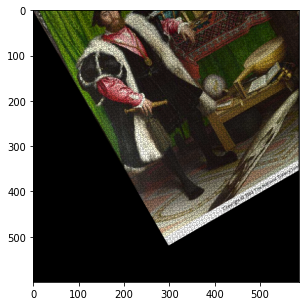

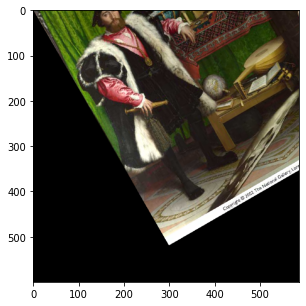

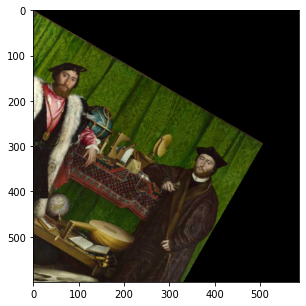

In [141]:
# (1) rotation with 30°
A = np.array([[ cos(30), -sin(30), 0], 
              [ sin(30), cos(30), 0],
              [       0,      0,  1]])

A1 = np.array([[    1.5,      0,  0], 
              [     0.5,      1,  0],
              [       0,      0,  1]])
A_rotate30 = np.array([[np.cos(np.deg2rad(30)), -np.sin(np.deg2rad(30)), 0],
               [np.sin(np.deg2rad(30)), np.cos(np.deg2rad(30)), 0],
               [0 ,0 , 1]])
A_scale0_7 = np.array([[0.7, 0, 0],
                       [0, 0.7, 0],
                       [0 , 0, 1]])
#gletscher
#ambassadors
affin_image = affin_transform_image(A_rotate30, 0, ambassadors, interpolation="naechster-nachbar")

## b) Führen Sie folgende affine Transformationen durch geeignete Wahl der Matrix A aus: 

> (1) Drehen Sie ein beliebiges Bild (z.B. gletscher.jpg) um 30◦

> (2) verkleinern Sie es um den Faktor 0.7

> (3) verkleinern Sie es in x-Richtung um den Faktor 0.8, vergrößern Sie es in y-Richtung um den Faktor 1.2

> (4) Dehnen Sie das Bild entlang der Diagonalen um 1.5, stauchen Sie senkrecht dazu um 0.5

> (5) Entzerren Sie das Objekt zu Füßen der Botschafter im Bild ambassadors.jpg.

> Vergleichen Sie dabei die Ergebnisse für Nächste-Nachbar- und bilineare Interpolation.









In [ ]:
# (1) rotation with 30°
A = np.array([[cos(30), sin(30)], [-sin(30), cos(30)]])
affin_transform_image(A, 0, image, interpolation="bilinear", color=False)

# (2) scaling smaller with factor 0.7
A = np.zeros((2, 2), float)
np.fill_diagonal(A, 0.7)
affin_transform_image(A, a0_, image, interpolation="bilinear", color=False)

# (3) scale x smaler with factor 0.8 and scale y up with factor 1.2
A = np.array([[0.8, 0], [0, 1.2]])
affin_transform_image(A, a0_, image, interpolation="bilinear", color=False)

# (4) shear diagonal with factor 1.5, shear vertical with factor 0.5
A = np.array([[1.5, 0], [0.5, 1]])
affin_transform_image(A, a0_, image, interpolation="bilinear", color=False)

# (5) equalize bottom of ambassador image with factor 2
A = np.array([[2, 0], [2, 1]])
affin_transform_image(A, a0_, image, interpolation="bilinear", color=True)

# (1)
affin_transform_image(A, a0_, image, interpolation="naechster-nachbar", color=False)

# (2)
affin_transform_image(A, a0_, image, interpolation="naechster-nachbar", color=False)

# (3)
affin_transform_image(A, a0_, image, interpolation="naechster-nachbar", color=False)

# (4)
affin_transform_image(A, a0_, image, interpolation="naechster-nachbar", color=False)

# (5)
affin_transform_image(A, a0_, image, interpolation="naechster-nachbar", color=True)

Nützliche Python-Funktionen:

> (1) zur Darstellung von Bildern können Sie die
Funktion imshow() aus dem Python-Paket matplotlib verwenden

> (2) Bilder können am bequemsten mit skimage.data.imread() aus dem Paket scikitimage eingelesen werden

> (3) Wenn Bilder in Python eingelesen werden, haben
sie meist den Datentyp uint8, für den nur eine begrenzte Funktionalität zur Verfügung steht. Wandeln Sie daher die Bilder nach dem Einlesen zuerst mit der
Funktion numpy.astype() in ein Fließkommaformat um und skalieren Sie
das Bild zwischen 0 und 1

> (4) Die Inverse einer Matrix wird mit der Funktion
numpy.linalg.inv() berechnet.
